# **Import Libraries**

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import KNNBaseline
from surprise.model_selection import GridSearchCV, cross_validate
from surprise import SVD
from surprise import SVDpp

# **Loading the data**

## **Reviews data**

In [2]:
df_video_games = pd.read_json('Video_Games.jsonl.gz',lines=True,compression='gzip',engine='pyarrow')

In [3]:
df_cds = pd.read_json('CDs_and_Vinyl.jsonl.gz', lines=True, compression='gzip', engine='pyarrow')

In [4]:
df_software = pd.read_json('Software.jsonl.gz', lines=True, compression='gzip', engine='pyarrow')

In [5]:
df_music = pd.read_json('Digital_Music.jsonl.gz',lines=True,compression='gzip',engine='pyarrow')

In [ ]:
#df_video_games.info()

## **Meta Data**

In [65]:
meta_video_games = pd.read_json('meta_Video_Games.jsonl.gz',lines=True,compression='gzip')

In [66]:
meta_cds = pd.read_json('meta_CDs_and_Vinyl.jsonl.gz',lines=True,compression='gzip')

In [67]:
meta_software = pd.read_json('meta_Software.jsonl.gz',lines=True,compression='gzip')

In [68]:
meta_music = pd.read_json('Digital_Music.jsonl.gz',lines=True,compression='gzip')

In [5]:
meta_video_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137269 entries, 0 to 137268
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   main_category    126234 non-null  object 
 1   title            137269 non-null  object 
 2   average_rating   137269 non-null  float64
 3   rating_number    137269 non-null  int64  
 4   features         137269 non-null  object 
 5   description      137269 non-null  object 
 6   price            62008 non-null   object 
 7   images           137269 non-null  object 
 8   videos           137269 non-null  object 
 9   store            132908 non-null  object 
 10  categories       137269 non-null  object 
 11  details          137269 non-null  object 
 12  parent_asin      137269 non-null  object 
 13  bought_together  0 non-null       float64
 14  subtitle         350 non-null     object 
 15  author           262 non-null     object 
dtypes: float64(2), int64(1), object(13)
me

# **Data Processing**

In [6]:
df = pd.concat([df_video_games, df_cds, df_software, df_music], ignore_index=True)

In [7]:
df2 = df[["rating", "user_id", "parent_asin"]]

In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14462503 entries, 0 to 14462502
Data columns (total 3 columns):
 #   Column       Dtype  
---  ------       -----  
 0   rating       float64
 1   user_id      object 
 2   parent_asin  object 
dtypes: float64(1), object(2)
memory usage: 331.0+ MB


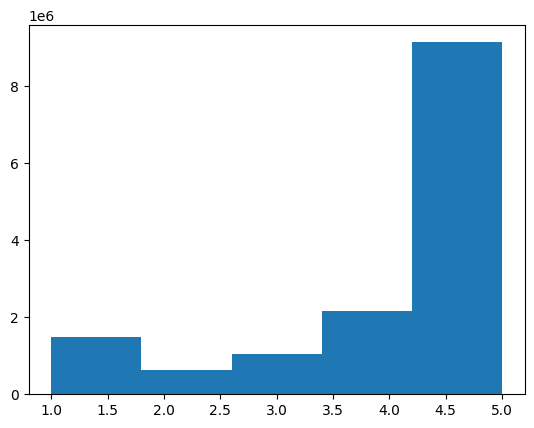

In [10]:
plt.hist(df2["rating"], bins=5) # how many ratings we have and how much
plt.show()

In [8]:
unique_users = len(df2["user_id"].unique())
unique_products = len(df2["parent_asin"].unique())
reviews_count = len(df2)
top = 5 # here we can change of what the most we want
print(f"Unique users: {unique_users}, Unique products: {unique_products}, Total reviews: {reviews_count}")

Unique users: 6533902, Unique products: 998679, Total reviews: 14462503


In [9]:
product_counts = df2["parent_asin"].value_counts()
popular_products = product_counts.reset_index()

In [12]:
num_products = (product_counts > top).sum()
print(f"Number of products with more than {top} reviews: {num_products}")

Number of products with more than 5 reviews: 235517


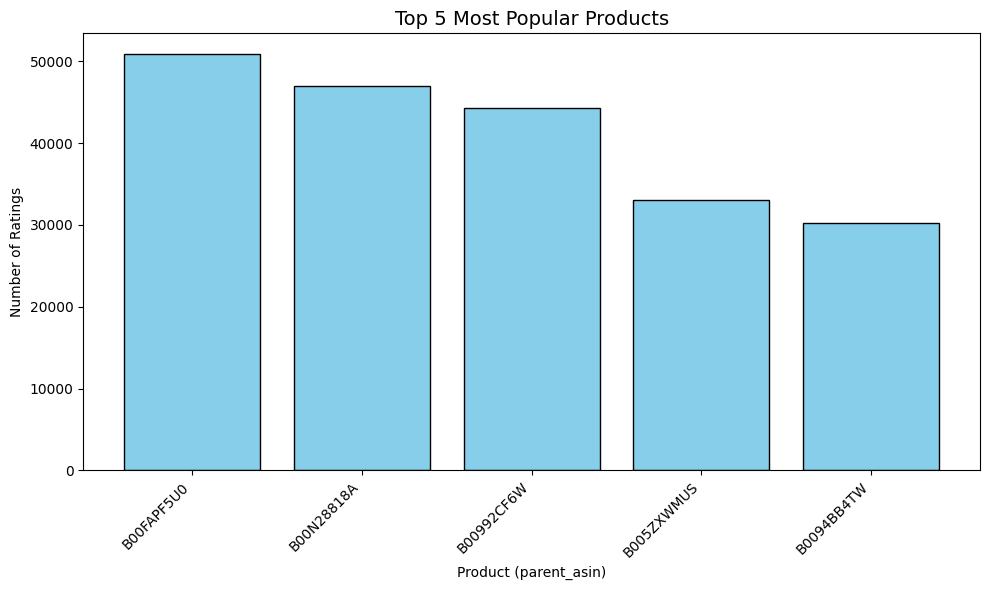

In [13]:
popular_products.columns = ["parent_asin", "rating"]
top15_product = popular_products.head(top)
plt.figure(figsize=(10, 6))
plt.bar(top15_product["parent_asin"], top15_product["rating"], color='skyblue', edgecolor='black')
plt.title(f"Top {top} Most Popular Products", fontsize=14)
plt.xlabel("Product (parent_asin)")
plt.ylabel("Number of Ratings")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [14]:
users_counts = df2["user_id"].value_counts()
popular_users = users_counts.reset_index()
popular_users

,user_id,count
0,AHACUCDYWYSRABKYXOLDMTDP2NQQ_1,2665
1,AH3FC6V3IUJIN2Y7BCZ7DN3IMMJQ,2548
2,AGAFM74L2RIJ5O36NNYH4Z5ISQNQ,2512
3,AHEDJIDSPVYCB3GPRZKGO7YTK6XQ,2137
4,AF2QM5NTJ52WVY7GOGHVQJNU5IMA,1970
...,...,...
6533897,AFMV5TYYPRDHULK7YVVM776DQ6EQ,1
6533898,AHTLMB6FM3WPBG3WGIKP5F3SJAFQ,1
6533899,AGNOGQBWFK4ZLVR7ZBMFXQVIQXDA,1
6533900,AFCKSP564DBBPEXJQHJAUTPKCP6A,1


In [15]:
num_active_users = (users_counts > top).sum()
print(f"Number of users with more than {top} reviews: {num_active_users}")

Number of users with more than 5 reviews: 382272


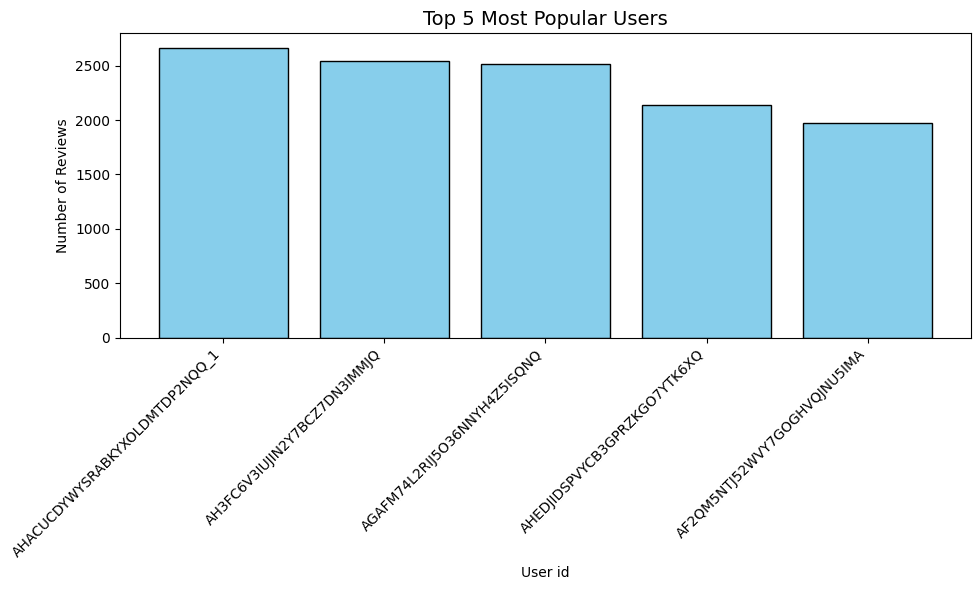

In [16]:
popular_users.columns = ["user_id", "rating"]
top15_user = popular_users.head(top)
plt.figure(figsize=(10, 6))
plt.bar(top15_user["user_id"], top15_user["rating"], color='skyblue', edgecolor='black')
plt.title(f"Top {top} Most Popular Users", fontsize=14)
plt.xlabel("User id")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## **Here i am checking thresholds for active items and users**

In [17]:
def calculate_sparsity(df_c, min_user_ratings, min_product_ratings):
    filtered_df = df_c.copy()
    user_counts = filtered_df["user_id"].value_counts()
    product_counts = filtered_df["parent_asin"].value_counts()

    filtered_df = filtered_df[filtered_df["user_id"].isin(user_counts[user_counts >= min_user_ratings].index)]
    filtered_df = filtered_df[filtered_df["parent_asin"].isin(product_counts[product_counts >= min_product_ratings].index)]

    n_users = filtered_df["user_id"].nunique()
    n_products = filtered_df["parent_asin"].nunique()
    n_ratings = len(filtered_df)
    sparsity = 1 - n_ratings / (n_users * n_products)

    return sparsity, n_users, n_products, n_ratings

for t in [15,20,25,30]:
    s, u, p, n = calculate_sparsity(df2, t, t)
    print(f"Threshold= {t:2d} Users={u:6d} Products={p:6d} Ratings={n:7d} Sparsity={s*100:6.2f}%")

Threshold= 15 Users= 73436 Products=101856 Ratings=1637055 Sparsity= 99.98%
Threshold= 20 Users= 43457 Products= 78168 Ratings=1166993 Sparsity= 99.97%
Threshold= 25 Users= 29160 Products= 62950 Ratings= 883096 Sparsity= 99.95%
Threshold= 30 Users= 21072 Products= 52692 Ratings= 695090 Sparsity= 99.94%


## **Here i am choosing the values of the active users and items**

In [10]:
min_user_ratings = 20
min_product_ratings = 20

user_counts = df2["user_id"].value_counts()
active_users = user_counts[user_counts >= min_user_ratings].index
df_active = df2[df2["user_id"].isin(active_users)]

product_counts = df_active["parent_asin"].value_counts()
popular_products = product_counts[product_counts >= min_product_ratings].index
df_active = df_active[df_active["parent_asin"].isin(popular_products)]

n_users = df_active["user_id"].nunique()
n_products = df_active["parent_asin"].nunique()
n_ratings = len(df_active)
sparsity = 1 - n_ratings / (n_users * n_products)

print(f"Filtered dataset:")
print(f"Users: {n_users}")
print(f"Products: {n_products}")
print(f"Ratings: {n_ratings}")
print(f"Sparsity: {sparsity*100:.2f}%")

print("\nSample of the filtered dataset:")
print(df_active.head())

Filtered dataset:
Users: 41872
Products: 14143
Ratings: 715533
Sparsity: 99.88%

Sample of the filtered dataset:
    rating                       user_id parent_asin
28     5.0  AFZUK3MTBIBEDQOPAK3OATUOUKLA  B0C3KYVDWT
30     5.0  AFZUK3MTBIBEDQOPAK3OATUOUKLA  B07VGRJDFY
33     5.0  AFZUK3MTBIBEDQOPAK3OATUOUKLA  B00KTORA0K
70     5.0  AEVQ3KP55X4XECXWMHN6DHIDBYFQ  B002JTX9WQ
93     3.0  AFW2PDT3AMT4X3PYQG7FJZH5FXFA  B00O2GW3EO


## **Here i am loading data and put data into a diffrent models**

In [11]:
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(df_active[['user_id', 'parent_asin', 'rating']],reader)

### **KNNBaseline**

In [12]:
param_grid = {'k': [20, 30, 40,],'min_k': [3, 5, 7],'sim_options': {'name': ['cosine'],'user_based': [False],'shrinkage': [0, 50, 100]}}

In [13]:
gs = GridSearchCV(KNNBaseline,param_grid, measures=['rmse', 'mae'],cv=3,joblib_verbose=1)

In [14]:
gs.fit(data)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Comput

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed: 55.2min


Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Comput

[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 89.4min finished


In [16]:
print("Best RMSE:", gs.best_score['rmse'])
print("Best params:", gs.best_params['rmse'])

Best RMSE: 0.9732917288128998
Best params: {'k': 40, 'min_k': 5, 'sim_options': {'name': 'cosine', 'user_based': False, 'shrinkage': 0}}


In [17]:
best_knn = KNNBaseline(
    k=gs.best_params['rmse']['k'],
    min_k=gs.best_params['rmse']['min_k'],
    sim_options=gs.best_params['rmse']['sim_options']
)

In [18]:
trainset, testset = train_test_split(data, test_size=0.2)

In [19]:
best_knn.fit(trainset)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [20]:
results_knn =cross_validate(best_knn,data,measures=['RMSE', 'MAE'],cv=3,verbose=True)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9701  0.9748  0.9741  0.9730  0.0021  
MAE (testset)     0.6888  0.6920  0.6917  0.6908  0.0014  
Fit time          60.99   64.52   57.80   61.11   2.75    
Test time         9.03    8.06    8.35    8.48    0.41    


### **SVD**

In [21]:
algo_svd =SVD()

In [22]:
results_svd =cross_validate(algo_svd,data,measures=['RMSE', 'MAE'],cv=3,verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9765  0.9765  0.9754  0.9761  0.0005  
MAE (testset)     0.7034  0.7034  0.7020  0.7029  0.0007  
Fit time          4.36    5.27    7.28    5.64    1.22    
Test time         1.71    3.43    2.99    2.71    0.73    


In [26]:
print("Mean MAE:",results_svd['test_mae'].mean())

Mean MAE: 0.7033039815254286


In [27]:
param_grid = {'n_factors':[50,60],'n_epochs':[40, 50],'lr_all':[0.005],
              'reg_all': [0.07, 0.09]}

gs = GridSearchCV(SVD,param_grid, measures=['rmse'],cv=3,joblib_verbose=2)
gs.fit(data)

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  3.8min finished


In [26]:
print("Best RMSE:", gs.best_score['rmse'])
print("Best params:", gs.best_params['rmse'])

Best RMSE: 0.9637184139354771
Best params: {'n_factors': 50, 'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.07}


### **SVD++**

In [28]:
algo_svdpp = SVDpp()

In [29]:
results = cross_validate(algo_svdpp, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9701  0.9686  0.9692  0.9693  0.0006  
MAE (testset)     0.6821  0.6819  0.6815  0.6818  0.0003  
Fit time          14.97   13.50   15.54   14.67   0.86    
Test time         8.77    8.09    10.05   8.97    0.81    


In [ ]:
param_grid = {'n_factors':[60, 70],'n_epochs':[30, 40],'lr_all':[0.005, 0.007],
              'reg_all': [0.09, 0.11]}

In [32]:
gs_svdpp = GridSearchCV(SVDpp,param_grid, measures=['rmse'],cv=3,joblib_verbose=2)
gs_svdpp.fit(data)

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 24.5min finished


In [33]:
print("Best RMSE:", gs_svdpp.best_score['rmse'])
print("Best params:", gs_svdpp.best_params['rmse'])

Best RMSE: 0.9606147285665482
Best params: {'n_factors': 60, 'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.09}


## **Here i am loading the models with the best params**

In [38]:
best_svd = SVD(n_factors=50,n_epochs=40,lr_all=0.005,reg_all=0.07)

In [42]:
knn = KNNBaseline(k=40, min_k=5, sim_options={'name': 'cosine', 'user_based': False, 'shrinkage': 0})

In [ ]:
svdpp = SVDpp(n_factors=60, n_epochs=40, lr_all=0.005, reg_all=0.09)

## **This is a functions for using a hybrid methods based on weight**

In [44]:
def hybrid_predict_weighted(u_id, i_id,svd, knn, w):
    svd_pred =svd.predict(u_id, i_id).est
    knn_pred =knn.predict(u_id,i_id).est
    return w* svd_pred + (1 -w)* knn_pred

In [45]:
def evaluate_weight(w,svd, knn,testset):
    errors =[]
    for u_id, i_id, true_r in testset:
        est =hybrid_predict_weighted(u_id, i_id,svd,knn, w)
        errors.append((true_r -est) **2)
    return np.sqrt(np.mean(errors))

In [51]:
def hybrid3_predict(uid, iid, svd, svdpp, knn, w1, w2, w3):
    svd_pred   = svd.predict(uid, iid).est
    svdpp_pred = svdpp.predict(uid, iid).est
    knn_pred   = knn.predict(uid, iid).est

    return (w1*svd_pred + w2*svdpp_pred + w3*knn_pred)

## **Train and Test**

In [46]:
trainset, testset = train_test_split(data, test_size=0.2)
best_svd.fit(trainset)
knn.fit(trainset)
svdpp.fit(trainset)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [53]:
weights = [
    (0.33,0.33,0.34), (0.2,0.4,0.4), (0.4,0.3,0.3), (0.5,0.3,0.2),
    (0.6,0.3,0.1), (0.3,0.5,0.2), (0.25,0.45,0.3), (0.1,0.7,0.2)
]
def evaluate(w1,w2,w3):
    errors = []
    for uid, iid, true_r in testset:
        est = hybrid3_predict(uid,iid,best_svd,svdpp,knn,w1,w2,w3)
        errors.append((true_r-est)**2)
    return np.sqrt(np.mean(errors))

results = {}
for w1,w2,w3 in weights:
    rmse = evaluate(w1,w2,w3)
    results[(w1,w2,w3)] = rmse
    print(f"Weights={w1,w2,w3} → RMSE={rmse:.5f}")

best = min(results, key=results.get)
print("\nBest config:", best, " RMSE:", results[best])

Weights=(0.33, 0.33, 0.34) → RMSE=0.94809
Weights=(0.2, 0.4, 0.4) → RMSE=0.94857
Weights=(0.4, 0.3, 0.3) → RMSE=0.94804
Weights=(0.5, 0.3, 0.2) → RMSE=0.94829
Weights=(0.6, 0.3, 0.1) → RMSE=0.94927
Weights=(0.3, 0.5, 0.2) → RMSE=0.94794
Weights=(0.25, 0.45, 0.3) → RMSE=0.94795
Weights=(0.1, 0.7, 0.2) → RMSE=0.94899

Best config: (0.3, 0.5, 0.2)  RMSE: 0.9479432824238154


In [48]:
weights = [0.6,0.61,0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7]

In [49]:
results = {}
for w in weights:
    rmse = evaluate_weight(w,best_svd, knn, testset)
    results[w] = rmse
    print(f"w={w:.2f} RMSE={rmse:.5f}")
best_w = min(results, key=results.get)
print("\nBest weight:", best_w, "with RMSE:", results[best_w])

w=0.60 RMSE=0.95047
w=0.61 RMSE=0.95045
w=0.62 RMSE=0.95044
w=0.63 RMSE=0.95043
w=0.64 RMSE=0.95043
w=0.65 RMSE=0.95044
w=0.66 RMSE=0.95046
w=0.67 RMSE=0.95048
w=0.68 RMSE=0.95051
w=0.69 RMSE=0.95055
w=0.70 RMSE=0.95059

Best weight: 0.63 with RMSE: 0.9504339267883017


In [64]:
summary = pd.DataFrame([
    {"Model": "KNNBaseline (Tuned)",          "RMSE": 0.9732},
    {"Model": "SVD (Tuned)",                  "RMSE": 0.9637},
    {"Model": "SVD++",                        "RMSE": 0.9606},
    {"Model": "Hybrid (SVD + KNN)",           "RMSE": 0.9504},
    {"Model": "Hybrid (SVD + SVD++ + KNN best)","RMSE": 0.94794},
])

summary

,Model,RMSE
0,KNNBaseline (Tuned),0.97320
1,SVD (Tuned),0.96370
2,SVD++,0.96060
3,Hybrid (SVD + KNN),0.95040
4,Hybrid (SVD + SVD++ + KNN best),0.94794


# **Data Processing of Meta Data**

In [70]:
meta = pd.concat([meta_video_games, meta_cds, meta_software, meta_music], ignore_index=True)

In [71]:
meta = meta[['parent_asin','title','main_category',
             'average_rating','rating_number','categories']]

In [72]:
meta = meta.drop_duplicates(subset='parent_asin')

In [73]:
df_full = df_active.merge(meta, on='parent_asin', how='left')

## **Just checking what the recommender**

In [81]:
users_in_test = list({uid for (uid,_,_) in testset})
user = random.choice(users_in_test)
print("Selected user:", user)

Selected user: AFCYKL6PZXZ3XTTVHGNFLCSIMJXQ


In [82]:
# all real ratings for this user
user_rated = df_active[df_active['user_id'] == user][['parent_asin','rating']]

# merge for product names
user_history = user_rated.merge(meta[['parent_asin','title']], on='parent_asin', how='left')

print("\n User Review History:")
for _,row in user_history.head(10).iterrows():    # show first 10
    print(f"{row['rating']} — {row['title']} ({row['parent_asin']})")


 User Review History:
5.0 — Rebel Heart       explicit_lyrics (B00T73ATFW)
5.0 — The London Sessions (B00NQFHD10)
4.0 — Unrepentant Geraldines (B00IFFK5O8)
4.0 — Loved Me Back to Life (B009CVRQLY)
3.0 — Prism (B00ERIUO02)
5.0 — Bangerz       Explicit Lyrics (B00EMAGCJM)
4.0 — The 20/20 Experience - 2 of 2 (B00DWFQ2N4)
5.0 — Closer To The Truth (B00DGGIXS6)
4.0 — Feels Like Home (B00DSTBMMU)
5.0 — Heartthrob (B00A4FOWYQ)


In [76]:
def hybrid(u_id, i_id, svd, svdpp, knn, w1=0.3, w2=0.5, w3=0.2):
    return (
        w1*svd.predict(u_id, i_id).est +
        w2*svdpp.predict(u_id, i_id).est +
        w3*knn.predict(u_id, i_id).est
    )

In [85]:
def recommend_hybrid(user, n=5, w1=0.3, w2=0.5, w3=0.2):
    rated = set(user_history['parent_asin'])

    candidates = [iid for iid in meta['parent_asin'].unique() if iid not in rated]

    scores = [(iid, hybrid(user, iid, best_svd, svdpp, knn, w1,w2,w3)) for iid in candidates]
    top = sorted(scores, key=lambda x: x[1], reverse=True)[:n]

    result = []
    for asin,score in top:
        title = meta.loc[meta['parent_asin']==asin,'title']
        title = title.values[0] if len(title)>0 else "Unknown"
        result.append((title, asin, score))

    return result

top5 = recommend_hybrid(user, n=10)

In [84]:
print(f"\nTOP-5 Hybrid Recommendations for {user}:\n")
for title, asin, score in top5:
    print(f"{title} → {score:.3f}  ({asin})")


TOP-5 Hybrid Recommendations for AFCYKL6PZXZ3XTTVHGNFLCSIMJXQ:

Darkness On The Edge Of Town → 5.000  (B0000025D0)
Hounds of Love → 5.000  (B000002U9E)
Violator → 4.996  (B000002LK1)
Revolver → 4.992  (B000002UAR)
Electric Ladyland → 4.987  (B000002P5U)


# **ALS**

In [27]:
class ALSRecommender:
    def __init__(self, n_factors=50, n_iterations=20, lambda_reg=0.1):
        self.n_factors = n_factors
        self.n_iterations = n_iterations
        self.lambda_reg = lambda_reg
        self.user_factors = None
        self.item_factors = None
        self.user_index = None
        self.item_index = None

    def fit(self, matrix):
        self.user_index = matrix.index.tolist()
        self.item_index = matrix.columns.tolist()
        n_users = len(self.user_index)
        n_items = len(self.item_index)

        self.user_factors = np.random.normal(0, 0.1, (n_users, self.n_factors))
        self.item_factors = np.random.normal(0, 0.1, (n_items, self.n_factors))

        R = matrix.fillna(0).values
        mask = (matrix.notna()).values.astype(float)

        for iteration in range(self.n_iterations):
            for u in range(n_users):
                items_rated = mask[u, :] > 0
                if items_rated.sum() == 0:
                    continue

                A = self.item_factors[items_rated].T @ self.item_factors[items_rated] + self.lambda_reg * np.eye(self.n_factors)
                V = self.item_factors[items_rated].T @ R[u, items_rated]
                self.user_factors[u] = np.linalg.solve(A, V)

            for i in range(n_items):
                users_rated = mask[:, i] > 0
                if users_rated.sum() == 0:
                    continue

                A = self.user_factors[users_rated].T @ self.user_factors[users_rated] + \
                    self.lambda_reg * np.eye(self.n_factors)
                V = self.user_factors[users_rated].T @ R[users_rated, i]
                self.item_factors[i] = np.linalg.solve(A, V)

            predictions = self.user_factors @ self.item_factors.T
            squared_errors = (R - predictions) ** 2 * mask
            rmse = np.sqrt(squared_errors.sum() / mask.sum())

    def predict(self, user_id, item_id):
        if user_id not in self.user_index or item_id not in self.item_index:
            return df_active['rating'].mean()

        user_idx = self.user_index.index(user_id)
        item_idx = self.item_index.index(item_id)

        prediction = np.dot(self.user_factors[user_idx], self.item_factors[item_idx])
        return np.clip(prediction, 1, 5)

    def recommend_for_user(self, user_id, n_recommendations=5, exclude_rated=True):
        if user_id not in self.user_index:
            return []

        user_idx = self.user_index.index(user_id)

        predictions = self.user_factors[user_idx] @ self.item_factors.T

        if exclude_rated:
            rated_items = user_product_matrix.loc[user_id].dropna().index.tolist()
            rated_indices = [self.item_index.index(item) for item in rated_items]
            predictions[rated_indices]=-np.inf

        top_indices = np.argsort(predictions)[::-1][:n_recommendations]

        recommendations = [(self.item_index[idx], np.clip(predictions[idx], 1, 5)) for idx in top_indices]
        return recommendations

    def recommend_similar_items(self, item_id, n_recommendations=5):
        if item_id not in self.item_index:
            return []
        item_idx = self.item_index.index(item_id)
        item_vector = self.item_factors[item_idx, :]
        similarities = cosine_similarity(item_vector.reshape(1, -1),self.item_factors).flatten()
        top_indices = np.argsort(similarities)[::-1][1:n_recommendations+1]

        recommendations = [(self.item_index[idx], similarities[idx]) for idx in top_indices]

        return recommendations

In [28]:
regularization_values = [0.01, 0.05, 0.1, 0.2]
results = []

for reg in regularization_values:
    print(f"lambda_reg: {reg}")
    als_recommender = ALSRecommender(n_factors=50, n_iterations=10, lambda_reg=reg)
    als_recommender.fit(user_product_matrix)

    R = user_product_matrix.fillna(0).values

    mask = (user_product_matrix.notna()).values.astype(float)
    predictions = als_recommender.user_factors @ als_recommender.item_factors.T
    squared_errors = (R - predictions) **2*mask
    rmse = np.sqrt(squared_errors.sum() / mask.sum())
    results.append((reg, rmse))
    print(f"Final rmse {reg}: {rmse}")

best_reg, best_rmse = sorted(results, key=lambda x: x[1])[0]

print(f"Best: {best_reg} rmse:{best_rmse}")



lambda_reg: 0.01
Final rmse 0.01: 0.017338595956481687
lambda_reg: 0.05
Final rmse 0.05: 0.028033784906522658
lambda_reg: 0.1
Final rmse 0.1: 0.03222708666161512
lambda_reg: 0.2
Final rmse 0.2: 0.03512644453502032
Best: 0.01 rmse:0.017338595956481687


In [29]:
als_recommender = ALSRecommender(n_factors=50, n_iterations=15, lambda_reg=best_reg)
als_recommender.fit(user_product_matrix)

In [99]:
id_num = 9
test_user = user_product_matrix.index[id_num]
test_item = user_product_matrix.columns[id_num]

In [100]:
product_name = merged.loc[merged['parent_asin'] == test_item, 'product_title'].dropna().unique()
product_name = product_name[0] if len(product_name) > 0 else "Unknown product"
print(f"Items {product_name}  {test_item}")

Items Soul Calibur - Sega Dreamcast  B00000K125


In [101]:
als_user_recommendations = als_recommender.recommend_for_user(test_user, n_recommendations=5)
print(f"Recommendations for {test_user}")

for item, score in als_user_recommendations:
    title = merged.loc[merged['parent_asin'] == item, 'product_title'].dropna().unique()
    title = title[0] if len(title) > 0 else "Unknown product"
    print(f"TITLE - {title:10s} ITEM - {item:10s} SCORE - {score}")

merged.loc[merged['user_id']==f'{test_user}']

Recommendations for AE2CF2WMOQ33745DGFSHINAYYIXA
TITLE - PowerA amiibo End Level Display ITEM - B073ST27MK SCORE - 3.5752096427716085
TITLE - Bloodborne Collectors Edition - PlayStation 4 ITEM - B00NOD0OTW SCORE - 2.9857922773301113
TITLE - Medal of Honor Warfighter - Xbox 360 ITEM - B007CSDEWO SCORE - 2.6191695032023583
TITLE - Nioh - PlayStation 4 ITEM - B01N4X95QL SCORE - 2.571047881035625
TITLE - Quantum Break – Xbox One ITEM - B00CMQTTZ2 SCORE - 2.490143413169985


,rating,review_title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,product_title,description,categories
675637,3.0,"Decent isolating headphones, but a bit of a mi...","These aren't bad, but I'm not quite as impress...",[],B0BPRXGCZ9,B0C4L6MW18,AE2CF2WMOQ33745DGFSHINAYYIXA,1676993318546,0,True,BOBOVR A2 Air VR Headphones - Compatible with ...,[],"[Video Games, PC, Virtual Reality, Accessories]"
675638,5.0,Great adapter!,This is the first 3rd party adapter I have ord...,[],B0BKW4J3RN,B0BN7J2KXD,AE2CF2WMOQ33745DGFSHINAYYIXA,1675702081288,1,True,Smlau XB1 Wireless Adapter Compatible with Xbo...,[],"[Video Games, Legacy Systems, Xbox Systems, Xb..."
675639,2.0,It works... sort of.,It was easy to use. Just plug it into a PC USB...,[],B0BNKXD8ZK,B0BNKXD8ZK,AE2CF2WMOQ33745DGFSHINAYYIXA,1671403805275,1,False,GuliKit Wireless Dual-mode Controller Adapter ...,[],"[Video Games, Legacy Systems, Xbox Systems, Xb..."
675640,2.0,"Not my favorite, made for a small face",So These are definitely not my favorite. The d...,[{'small_image_url': 'https://m.media-amazon.c...,B0BL7B85TJ,B0BL7B85TJ,AE2CF2WMOQ33745DGFSHINAYYIXA,1671139195802,0,False,XROS VR Upgraded Face Cushion Compatible with ...,[],"[Video Games, PC, Virtual Reality, Headsets]"
675641,1.0,Couldn't get it to work.,I tried to get this to work. I attempted to up...,[],B0BHZ7KC37,B0BHZ7KC37,AE2CF2WMOQ33745DGFSHINAYYIXA,1670792477566,0,True,"OLCLSS Wireless Adapter for Xbox One, AOJAKI U...",[],"[Video Games, Xbox One, Accessories, Cables & ..."
675642,4.0,"Nice powerful fan, but the weight is noticeable",So here are my thoughts so far...<br /><br />P...,[{'small_image_url': 'https://m.media-amazon.c...,B0BKXV3QH7,B0BKXV3QH7,AE2CF2WMOQ33745DGFSHINAYYIXA,1670212905167,7,False,VR Cooling Fan with Soft Face Cover/Pad for Oc...,[],"[Video Games, PC, Virtual Reality, Headsets]"
675643,5.0,"Really great, well balanced rechargeable grips!",These are great controller grips! I use them f...,[{'small_image_url': 'https://m.media-amazon.c...,B0BHSRVVSV,B0C8TFTNPT,AE2CF2WMOQ33745DGFSHINAYYIXA,1668974357030,0,False,Aubika Rechargeable Controller Grips Cover for...,[],"[Video Games, Virtual Reality, Standalone Hard..."
675644,5.0,Great spare battery for Oculus or anything tha...,So I saw this and I was fascinated by the conc...,[{'small_image_url': 'https://m.media-amazon.c...,B0BFF97R18,B0BFF97R18,AE2CF2WMOQ33745DGFSHINAYYIXA,1668127346702,1,False,AMVR 8000mAh Battery Pack Compatible with Ques...,[],"[Video Games, PC, Virtual Reality, Headsets]"
675645,4.0,"Fits everything I need, no padding",So I travel a lot for work and bring my Oculus...,[{'small_image_url': 'https://m.media-amazon.c...,B0BCYXFTNG,B0C2HBQ1B3,AE2CF2WMOQ33745DGFSHINAYYIXA,1668122895300,0,False,DEVASO Carrying Case for Meta Quest Pro/Meta Q...,[],"[Video Games, PC, Virtual Reality, Headsets]"
675646,5.0,Nice 3rd party head strap for the Meta Quest 2,This KIWI design headphone head strap for the ...,[{'small_image_url': 'https://m.media-amazon.c...,B09ZV415VH,B0BXKJ4FTC,AE2CF2WMOQ33745DGFSHINAYYIXA,1667832150430,1,False,KIWI design Head Strap with Halo Controller Pr...,[],"[Video Games, PC, Virtual Reality, Accessories]"


In [102]:
als_item_recommendations = als_recommender.recommend_similar_items(test_item, n_recommendations=5)
print(f"Items '{product_name}'")
for item, score in als_item_recommendations:
    title = merged.loc[merged['parent_asin'] == item, 'product_title'].dropna().unique()
    title = title[0] if len(title) > 0 else "Unknown product"
    print(f"TITLE - {title:10s} ITEM - {item:10s} SCORE - {score}")

Items 'Soul Calibur - Sega Dreamcast'
TITLE - Sonic Adventure - Sega Dreamcast ITEM - B00000K3X9 SCORE - 0.8952663572971932
TITLE - The Legend of Dragoon - Playstation ITEM - B00004S9AF SCORE - 0.6311009689079011
TITLE - Shadow The Hedgehog - PlayStation 2 ITEM - B001EYUXUI SCORE - 0.5182417098301451
TITLE - PlayStation 3 Doubleshock III Wireless Controller (Black) ITEM - B000K1CS5Y SCORE - 0.49967837968258977
TITLE - Yakuza Kiwami - PlayStation Hits - PlayStation 4 ITEM - B071CK7P1L SCORE - 0.49647992252422013


# **Matrix Factorization**

In [34]:
class Matrix_Factorization_Recommender:
    def __init__(self, n_factors=50):
        self.n_factors = n_factors
        self.user_factors = None
        self.item_factors = None
        self.user_index = None
        self.item_index = None
        self.global_mean = None

    def fit(self, matrix):
        self.user_index = matrix.index.tolist()
        self.item_index = matrix.columns.tolist()

        filled_matrix = matrix.fillna(0)
        self.global_mean = df_active['rating'].mean()

        centered_matrix = filled_matrix - self.global_mean

        U, sigma, Vt = svds(centered_matrix.values, k=self.n_factors)
        self.user_factors = U
        self.item_factors = Vt.T
        self.sigma = np.diag(sigma)

    def predict(self, user_id, item_id):
        if user_id not in self.user_index or item_id not in self.item_index:
            return self.global_mean

        user_idx = self.user_index.index(user_id)
        item_idx = self.item_index.index(item_id)

        prediction = (self.global_mean +np.dot(np.dot(self.user_factors[user_idx, :], self.sigma),self.item_factors[item_idx, :]))

        return np.clip(prediction, 1, 5)

    def recommend_for_user(self, user_id, n_recommendations=5, exclude_rated=True):
        if user_id not in self.user_index:
            return []

        user_idx = self.user_index.index(user_id)

        user_vector = np.dot(np.dot(self.user_factors[user_idx, :], self.sigma),self.item_factors.T) + self.global_mean

        if exclude_rated:
            rated_items = user_product_matrix.loc[user_id].dropna().index.tolist()
            rated_indices = [self.item_index.index(item) for item in rated_items]
            user_vector[rated_indices] = -np.inf

        top_indices = np.argsort(user_vector)[::-1][:n_recommendations]

        recommendations = [(self.item_index[idx], user_vector[idx])for idx in top_indices]

        return recommendations


    def recommend_similar_items(self, item_id, n_recommendations=5):
        if item_id not in self.item_index:
            return []

        item_idx = self.item_index.index(item_id)
        item_vector = self.item_factors[item_idx, :]

        similarities = cosine_similarity(item_vector.reshape(1, -1),self.item_factors).flatten()

        top_indices = np.argsort(similarities)[::-1][1:n_recommendations+1]

        recommendations = [
            (self.item_index[idx], similarities[idx])
            for idx in top_indices]
        return recommendations

In [35]:
mf_recommender = Matrix_Factorization_Recommender(n_factors=50)
mf_recommender.fit(user_product_matrix)

In [103]:
id_num = 3
test_user = user_product_matrix.index[id_num]
test_item = user_product_matrix.columns[id_num]

In [104]:
product_name = merged.loc[merged['parent_asin'] == test_item, 'product_title'].dropna().unique()
product_name = product_name[0] if len(product_name) > 0 else "Unknown product"
print(f"Items {product_name}  {test_item}")

Items The Legend of Zelda: Ocarina of Time  B00000DMB3


In [105]:
user_recommendations = mf_recommender.recommend_for_user(test_user, n_recommendations=5)
print(f"Recommendations for {test_user}")
for item, score in user_recommendations:
    title = merged.loc[merged['parent_asin'] == item, 'product_title'].dropna().unique()
    title = title[0] if len(title) > 0 else "Unknown product"
    print(f"TITLE - {title:10s} ITEM - {item:10s} ")

merged.loc[merged['user_id']==f'{test_user}']


Recommendations for AE25Y2LOSEKTPUJFDPWYJNYCQ7EQ
TITLE - Mario Kart 8 Deluxe – Booster Course Pass - Nintendo Switch [Digital Code] ITEM - B087NN2K41 
TITLE - Super Mario Odyssey - Nintendo Switch ITEM - B087SHFL9B 
TITLE - SanDisk 128GB microSDXC-Card, Licensed for Nintendo-Switch - SDSQXAO-128G-GNCZN ITEM - B0C3KYVDWT 
TITLE - Luigi's Mansion 3 - Nintendo Switch [Digital Code] ITEM - B087NM8BB6 
TITLE - $45 Nintendo eShop Gift Card [Digital Code] ITEM - B07ZJ6RY1W 


,rating,review_title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,product_title,description,categories
1423680,5.0,Excelente juego.,Excelente juego.,[],B07DCLW2F3,B07DFYXS9X,AE25Y2LOSEKTPUJFDPWYJNYCQ7EQ,1630420585881,0,True,Mega Man 11 - Nintendo Switch [Digital Code],[Mega Man jumps into battle once again! This e...,"[Video Games, Nintendo Switch, Games]"
1423681,5.0,Excelente torre de almacenamiento,"Excelente producto para almacenar tus juegos, ...",[],B08MPPJ9K1,B09WCY81BV,AE25Y2LOSEKTPUJFDPWYJNYCQ7EQ,1630420478745,0,True,"HEATFUN PS5 Game Organizer, Storage Tower Comp...",[],"[Video Games, PlayStation 5, Accessories, Case..."
1423682,5.0,Excelente base para cargar los controles.,"Excelente base para cargar los controles, muy ...",[],B07YWYXPC1,B07YWYXPC1,AE25Y2LOSEKTPUJFDPWYJNYCQ7EQ,1630420400092,0,True,"PS4 Controller Charger, PS4 Charger USB Chargi...",[],"[Video Games, PlayStation 4, Accessories, Cabl..."
1423683,5.0,Excelente Mouse.,"Excelente Mouse, muy cómodo y de buena calidad...",[],B07YN82X3B,B07YN82X3B,AE25Y2LOSEKTPUJFDPWYJNYCQ7EQ,1630420243244,0,True,"Logitech G203 Wired Gaming Mouse, 8,000 DPI, R...","[G203 Lightsync is ready to play with an 8, 00...","[Video Games, PC, Accessories, Gaming Mice]"
1423684,5.0,Excelente base para cargar los controles.,"Excelente base para cargar los controles, muy ...",[],B08FC6Y4VG,B08FC6Y4VG,AE25Y2LOSEKTPUJFDPWYJNYCQ7EQ,1630419981537,0,True,Playstation DualSense Charging Station,[Charge up to two DualSense wireless controlle...,"[Video Games, PlayStation 5, Accessories, Batt..."
1423685,5.0,Excelente teclado.,"Excelente teclado, muy cómodo, diseño y buena ...",[],B07QGHK6Q8,B0C6KR97PD,AE25Y2LOSEKTPUJFDPWYJNYCQ7EQ,1630419934273,0,True,"Logitech G213 Prodigy Gaming Keyboard, LIGHTSY...","[G213 Prodigy slim body is durable, precise, a...","[Video Games, PC, Accessories, Gaming Keyboards]"
1423686,5.0,Excelente para guardar los controles.,Excelente producto para guardar los controles ...,[],B08RS3YY8J,B09W5LSBKY,AE25Y2LOSEKTPUJFDPWYJNYCQ7EQ,1630419662641,0,True,sisma Travel Case Compatible with PS5 DualSens...,[],"[Video Games, PlayStation 5, Accessories, Case..."
1423687,5.0,Excelente funda protectora para el Playstation 5,"Excelente funda protectora, de buena calidad, ...",[],B08PZ3SLRV,B08PZ3SLRV,AE25Y2LOSEKTPUJFDPWYJNYCQ7EQ,1630419604952,0,True,Esimen Sleeve Protective Case Dust Cover for P...,[],"[Video Games, PlayStation 5, Accessories, Case..."
1423688,5.0,Excelente juego!,De los mejores juegos que no debe faltar en tu...,[],B07DCNTRR3,B074MD45CX,AE25Y2LOSEKTPUJFDPWYJNYCQ7EQ,1630040669265,0,True,Mario + Rabbids Kingdom Battle Gold Edition,[Discover Mario + Rabbids Kingdom Battle Gold ...,"[Video Games, Nintendo Switch, Games]"
1423689,5.0,Es un juegazo.,"De los mejores juegos de la consola, no debe f...",[],B01N5OKGLH,B08D3XL1KF,AE25Y2LOSEKTPUJFDPWYJNYCQ7EQ,1630040501217,0,True,Super Smash Bros. Ultimate: Challenger Pack 2 ...,[The Hero from the DRAGON QUEST XI game joins ...,"[Video Games, Nintendo Switch, Games]"


In [106]:
item_recommendations = mf_recommender.recommend_similar_items(test_item, n_recommendations=5)
print(f"Items '{product_name}'")
for item, score in item_recommendations:
    title = merged.loc[merged['parent_asin'] == item, 'product_title'].dropna().unique()
    title = title[0] if len(title) > 0 else "Unknown product"
    print(f"TITLE - {title:10s} ITEM - {item:10s}")

Items 'The Legend of Zelda: Ocarina of Time'
TITLE - Perfect Dark ITEM - B00002STGL
TITLE - Luigi's Mansion - Gamecube ITEM - B00005Q8LR
TITLE - Super Mario Sunshine ITEM - B000066JRN
TITLE - Animal Crossing ITEM - B00006FWTX
TITLE - The Legend of Zelda: The Wind Waker ITEM - B000084318


In [6]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise import accuracy

In [7]:
df["user_id"] = df["user_id"].astype("category")
df["parent_asin"] = df["parent_asin"].astype("category")

df["user_idx"] = df["user_id"].cat.codes
df["item_idx"] = df["parent_asin"].cat.codes

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4624615 entries, 0 to 4624614
Data columns (total 12 columns):
 #   Column             Dtype   
---  ------             -----   
 0   rating             float64 
 1   title              object  
 2   text               object  
 3   images             object  
 4   asin               object  
 5   parent_asin        category
 6   user_id            category
 7   timestamp          int64   
 8   helpful_vote       int64   
 9   verified_purchase  bool    
 10  user_idx           int32   
 11  item_idx           int32   
dtypes: bool(1), category(2), float64(1), int32(2), int64(2), object(4)
memory usage: 412.6+ MB


In [9]:
df_sample = df.sample(500_000, random_state=42)

In [10]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 1112677 to 3976391
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   rating             500000 non-null  float64 
 1   title              500000 non-null  object  
 2   text               500000 non-null  object  
 3   images             500000 non-null  object  
 4   asin               500000 non-null  object  
 5   parent_asin        500000 non-null  category
 6   user_id            500000 non-null  category
 7   timestamp          500000 non-null  int64   
 8   helpful_vote       500000 non-null  int64   
 9   verified_purchase  500000 non-null  bool    
 10  user_idx           500000 non-null  int32   
 11  item_idx           500000 non-null  int32   
dtypes: bool(1), category(2), float64(1), int32(2), int64(2), object(4)
memory usage: 129.3+ MB


In [9]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['user_idx', 'item_idx', 'rating']], reader)
train, test = train_test_split(data, test_size=0.1)

In [13]:
param_grid = {
    "n_factors": [50, 100, 150],
    "reg_all": [0.02, 0.05, 0.1],
    "n_epochs": [20, 40, 60],
    "lr_all": [0.002, 0.005, 0.01]
}

gs = GridSearchCV(
    SVD,
    param_grid,
    measures=['rmse', 'mae'],
    cv=3,
    joblib_verbose=5,
)
gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])
best_params = gs.best_params['rmse']

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:  2.5min
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed: 12.1min
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed: 32.8min


1.369025732875131
{'n_factors': 150, 'reg_all': 0.1, 'n_epochs': 40, 'lr_all': 0.01}


[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed: 56.2min finished


In [16]:
data_all = Dataset.load_from_df(df[["user_idx", "item_idx", "rating"]],reader)

In [20]:
trainset, testset = train_test_split(data_all, test_size=0.1)

In [21]:
best_params = {
    'n_factors': 150,
    'reg_all': 0.1,
    'n_epochs': 40,
    'lr_all': 0.01}

In [10]:
model = SVD(
    n_factors=100,
    reg_all=0.08,
    n_epochs=30,
    lr_all=0.01
)

model.fit(train)

In [11]:
predictions = model.test(test)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 1.3121
MAE:  1.0264


In [ ]:
user_item_matrix = df.pivot_table(
    index="user_idx",
    columns="item_idx",
    values="rating"
).fillna(0)

/var/folders/ln/ksggc_bs687c9c0qnq78dnhh0000gn/T/ipykernel_90016/1344324884.py:1: PerformanceWarning: The following operation may generate 379720769344 cells in the resulting pandas object.
  user_item_matrix = df.pivot_table(


In [ ]:
item_item_sim = cosine_similarity(user_item_matrix.T)
item_item_sim = np.array(item_item_sim)